# Train the ConvLSTM Model..

Use this Latent Space for the final model.

In [1]:
import numpy as np
import cv2
import tensorflow as tf
import keras
from tensorflow.python.distribute.mirrored_strategy import MirroredStrategy

from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
#from keras.utils import to_categorical
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import (ConvLSTM2D, BatchNormalization, Convolution3D, Convolution2D, Conv2D, Dropout,
                          TimeDistributed, MaxPooling2D, MaxPooling3D, UpSampling2D, UpSampling3D, Input,  AveragePooling3D)

import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import os
import gc

2023-06-12 12:55:10.242483: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


In [2]:
# os.environ['TF_XLA_FLAGS'] = '--tf_xla_enable_xla_devices'
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ['CUDA_VISIBLE_DEVICES'] = "2"
# os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
# os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

In [3]:
import tensorflow.keras.backend as K

In [4]:
data = np.load("/home/sullah/PycharmProjects/EDSR/Alphorn_Project/dataset_after_augmentation_256x256/del_data_after_augmentation_256x256.npy", mmap_mode='r+')

In [5]:
data = data.reshape((1900, 32, 256, 256, 1))
print(data.shape)

(1900, 32, 256, 256, 1)


In [6]:
# def PSNR(y_true,y_pred):
#   mse=tf.reduce_mean( (y_true - y_pred) ** 2 )
#   return 20 * log10(1 / (mse ** 0.5))

# def log10(x):
#   numerator = tf.math.log(x)
#   denominator = tf.math.log(tf.constant(10, dtype=numerator.dtype))
#   return numerator / denominator

# def pixel_MSE(y_true,y_pred):
#   return tf.reduce_mean( (y_true - y_pred) ** 2 )


def PSNR(orig, pred):
	# cast the target images to integer
	orig = orig * 255.0
	orig = tf.cast(orig, tf.uint8)
	orig = tf.clip_by_value(orig, 0, 255)
	# cast the predicted images to integer
	pred = pred * 255.0
	pred = tf.cast(pred, tf.uint8)
	pred = tf.clip_by_value(pred, 0, 255)
	# return the psnr
	return tf.image.psnr(orig, pred, max_val=255)

In [7]:
def custom_save(filepath_, *args, **kwargs):                           
    """ Overwrite save function to save the two sub-models """         
    global encoder, decoder                                            
                                                                       
    # fix name                                                         
    path, ext = os.path.splitext(filepath_)                            
                                                                       
    # save encoder/decoder separately                                  
    encoder.save(path + '-encoder_fully_ConvLSTM1.h5', *args, **kwargs) 
    decoder.save(path + '-decoder_fully_ConvLSTM1.h5', *args, **kwargs) 

In [8]:
#encoder
inputs = tf.keras.Input(shape=(32, 256, 256, 1))
       
net1 = ConvLSTM2D(filters=32, kernel_size=3, padding='same', return_sequences=True)(inputs) 

max_pool1 = MaxPooling3D(pool_size=(1, 2, 2), strides=(1, 2, 2), padding='same')(net1)
    
bn1 = BatchNormalization()(max_pool1)
 
net2 = ConvLSTM2D(filters=192, kernel_size=3, padding='same', return_sequences=True)(bn1) 

max_pool2 = MaxPooling3D(pool_size=(1, 2, 2), strides=(1, 2, 2), padding='same')(net2)

bn2 = BatchNormalization()(max_pool2)
    
net3 = ConvLSTM2D(filters=192, kernel_size=3, padding='same', return_sequences=True)(bn2) 

max_pool3 = MaxPooling3D(pool_size=(1, 2, 2), strides=(1, 2, 2), padding='same')(net3)

bn3 = BatchNormalization(name = "Latent_Space")(max_pool3)


encoder = Model(inputs, bn3, name='encoder')

encoder.summary()

2023-06-12 12:55:14.252352: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2023-06-12 12:55:14.254025: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2023-06-12 12:55:14.330206: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:86:00.0 name: Tesla V100S-PCIE-32GB computeCapability: 7.0
coreClock: 1.597GHz coreCount: 80 deviceMemorySize: 31.75GiB deviceMemoryBandwidth: 1.03TiB/s
2023-06-12 12:55:14.330302: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2023-06-12 12:55:14.333242: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2023-06-12 12:55:14.333364: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.so.10
2

Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 256, 256, 1)] 0         
_________________________________________________________________
conv_lst_m2d (ConvLSTM2D)    (None, 32, 256, 256, 32)  38144     
_________________________________________________________________
max_pooling3d (MaxPooling3D) (None, 32, 128, 128, 32)  0         
_________________________________________________________________
batch_normalization (BatchNo (None, 32, 128, 128, 32)  128       
_________________________________________________________________
conv_lst_m2d_1 (ConvLSTM2D)  (None, 32, 128, 128, 192) 1549056   
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 32, 64, 64, 192)   0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 64, 64, 192)   768 

In [9]:
#decoder
decoder_inputs = tf.keras.Input(shape=(32,32,32,192))

net4 = ConvLSTM2D(filters=192, kernel_size=3, padding='same', return_sequences=True)(decoder_inputs) 

up1 = UpSampling3D((1, 2, 2))(net4)
    
bn4 = BatchNormalization()(up1)
    
net5 = ConvLSTM2D(filters=192, kernel_size=3, padding='same', return_sequences=True)(bn4) 

up2 = UpSampling3D((1, 2, 2))(net5)
    
bn5 = BatchNormalization()(up2)
    
net6 = ConvLSTM2D(filters=32, kernel_size=3, padding='same', return_sequences=True)(bn5) 

up3 = UpSampling3D((1, 2, 2))(net6)
    
bn6 = BatchNormalization()(up3)

out = Conv2D(filters=1, kernel_size=(3, 3), activation='sigmoid', padding='same', data_format='channels_last')(bn6)

decoder = Model(decoder_inputs, out, name='decoder')

decoder.summary()

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 32, 32, 32, 192)] 0         
_________________________________________________________________
conv_lst_m2d_3 (ConvLSTM2D)  (None, 32, 32, 32, 192)   2654976   
_________________________________________________________________
up_sampling3d (UpSampling3D) (None, 32, 64, 64, 192)   0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 32, 64, 64, 192)   768       
_________________________________________________________________
conv_lst_m2d_4 (ConvLSTM2D)  (None, 32, 64, 64, 192)   2654976   
_________________________________________________________________
up_sampling3d_1 (UpSampling3 (None, 32, 128, 128, 192) 0         
_________________________________________________________________
batch_normalization_3 (Batch (None, 32, 128, 128, 192) 768 

In [10]:
autoencoder_input = inputs
autoencoder_output = decoder(encoder(autoencoder_input))
autoencoder = Model(autoencoder_input, autoencoder_output, name='autoencoder')
opt = tf.optimizers.Adam(learning_rate=3e-4)
autoencoder.compile(loss= 'mse', optimizer=opt, metrics=PSNR) 
autoencoder.summary()

Model: "autoencoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 256, 256, 1)] 0         
_________________________________________________________________
encoder (Functional)         (None, 32, 32, 32, 192)   4243840   
_________________________________________________________________
decoder (Functional)         (None, 32, 256, 256, 1)   5570081   
Total params: 9,813,921
Trainable params: 9,812,257
Non-trainable params: 1,664
_________________________________________________________________


In [11]:
def pearson_r(y_true, y_pred):
    
    epsilon = 10e-5
    x = y_true
    y = y_pred
    mx = K.mean(x, axis=0)
    my = K.mean(y, axis=0)
    xm, ym = x - mx, y - my
    r_num = K.sum(xm * ym)
    x_square_sum = K.sum(xm * xm)
    y_square_sum = K.sum(ym * ym)
    r_den = K.sqrt(x_square_sum * y_square_sum)
    r = r_num / (r_den + epsilon)
    return K.mean(r)

In [12]:
# dependencies = {'PSNR': PSNR, 'pearson_r': pearson_r}

#  # load the saved model
# model = load_model('VGG16_withoutGT_with_features_norm2.h5', custom_objects=dependencies)

In [13]:
def start_training():

    print(data.shape)
    filepath_ ='/home/sullah/PycharmProjects/EDSR/Alphorn_Project/for_professor_method_after_augmentation_256x256_another_try'
    
    es = EarlyStopping(monitor='val_PSNR', mode='max', patience=20)
    
    # will stop if validation PSNR is not improving till 20 epoches.
    
    ms = ModelCheckpoint('ConvLSTM_with_Pooling_with_MSE_autoencoder_decoder1.h5', monitor='val_PSNR', mode='max', save_best_only=True)
        
    setattr(autoencoder, 'save', custom_save)
    training_history = autoencoder.fit(x=data, y=data, validation_split=0.05, batch_size=2, epochs=1000, verbose=1,
                                     callbacks=[es, ms], use_multiprocessing=True, workers=6)

    # Plot train vs test accuracy per epoch
    plt.figure(dpi=1200)

    # Use the history metrics
    plt.plot(training_history.history['PSNR'])
    plt.plot(training_history.history['val_PSNR'])

    plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(50))

    # Make it pretty
    plt.title('PSNR of Train and Validation Data')
    plt.ylabel('PSNR values')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'])
    plt.savefig('ConvLSTM_with_Pooling_with_MSE_autoencoder_decoder1.png')
    plt.show()

(1900, 32, 256, 256, 1)


2023-06-12 12:56:11.132883: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2023-06-12 12:56:11.151621: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2100000000 Hz


Epoch 1/1000


2023-06-12 12:56:27.100923: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.7
2023-06-12 12:56:31.341458: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2023-06-12 12:56:32.731543: W tensorflow/core/common_runtime/bfc_allocator.cc:248] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.18GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2023-06-12 12:56:32.800648: W tensorflow/core/common_runtime/bfc_allocator.cc:248] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.04GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2023-06-12 12:56:32.805012: W tensorflow/core/common_runtime/bfc_allocator.cc:248] Allocator (GPU_0_bfc) r

903/903 [==============================] - 1821s 2s/step - loss: 0.0122 - PSNR: 20.8298 - val_loss: 0.0011 - val_PSNR: 30.4391
Epoch 2/1000
903/903 [==============================] - 1779s 2s/step - loss: 5.0756e-04 - PSNR: 33.9195 - val_loss: 2.3321e-04 - val_PSNR: 37.2416
Epoch 3/1000
903/903 [==============================] - 1779s 2s/step - loss: 2.1211e-04 - PSNR: 37.5342 - val_loss: 1.5442e-04 - val_PSNR: 38.6623
Epoch 4/1000
903/903 [==============================] - 1775s 2s/step - loss: 1.4020e-04 - PSNR: 39.2189 - val_loss: 1.5445e-04 - val_PSNR: 39.3794
Epoch 5/1000
903/903 [==============================] - 1777s 2s/step - loss: 1.1345e-04 - PSNR: 40.1639 - val_loss: 1.0541e-04 - val_PSNR: 40.5423
Epoch 6/1000
903/903 [==============================] - 1774s 2s/step - loss: 9.2906e-05 - PSNR: 41.0597 - val_loss: 7.8295e-05 - val_PSNR: 41.7546
Epoch 7/1000
903/903 [==============================] - 1772s 2s/step - loss: 8.0697e-05 - PSNR: 41.6583 - val_loss: 1.7857e-04 - val

903/903 [==============================] - 1769s 2s/step - loss: 4.0881e-06 - PSNR: 51.3858 - val_loss: 4.5068e-06 - val_PSNR: 51.0867
Epoch 112/1000
903/903 [==============================] - 1771s 2s/step - loss: 5.3515e-06 - PSNR: 50.8449 - val_loss: 7.7904e-06 - val_PSNR: 49.6271
Epoch 113/1000
903/903 [==============================] - 1772s 2s/step - loss: 5.8720e-06 - PSNR: 50.6578 - val_loss: 3.6807e-06 - val_PSNR: 51.3731
Epoch 114/1000
903/903 [==============================] - 1774s 2s/step - loss: 4.1496e-06 - PSNR: 51.3906 - val_loss: 5.0724e-05 - val_PSNR: 48.5671
Epoch 115/1000
903/903 [==============================] - 1774s 2s/step - loss: 4.4691e-06 - PSNR: 51.1906 - val_loss: 4.1609e-06 - val_PSNR: 51.1675
Epoch 116/1000
903/903 [==============================] - 1768s 2s/step - loss: 4.4688e-06 - PSNR: 51.2088 - val_loss: 5.9146e-06 - val_PSNR: 50.3499
Epoch 117/1000
903/903 [==============================] - 1770s 2s/step - loss: 4.6065e-06 - PSNR: 51.1520 - val_lo

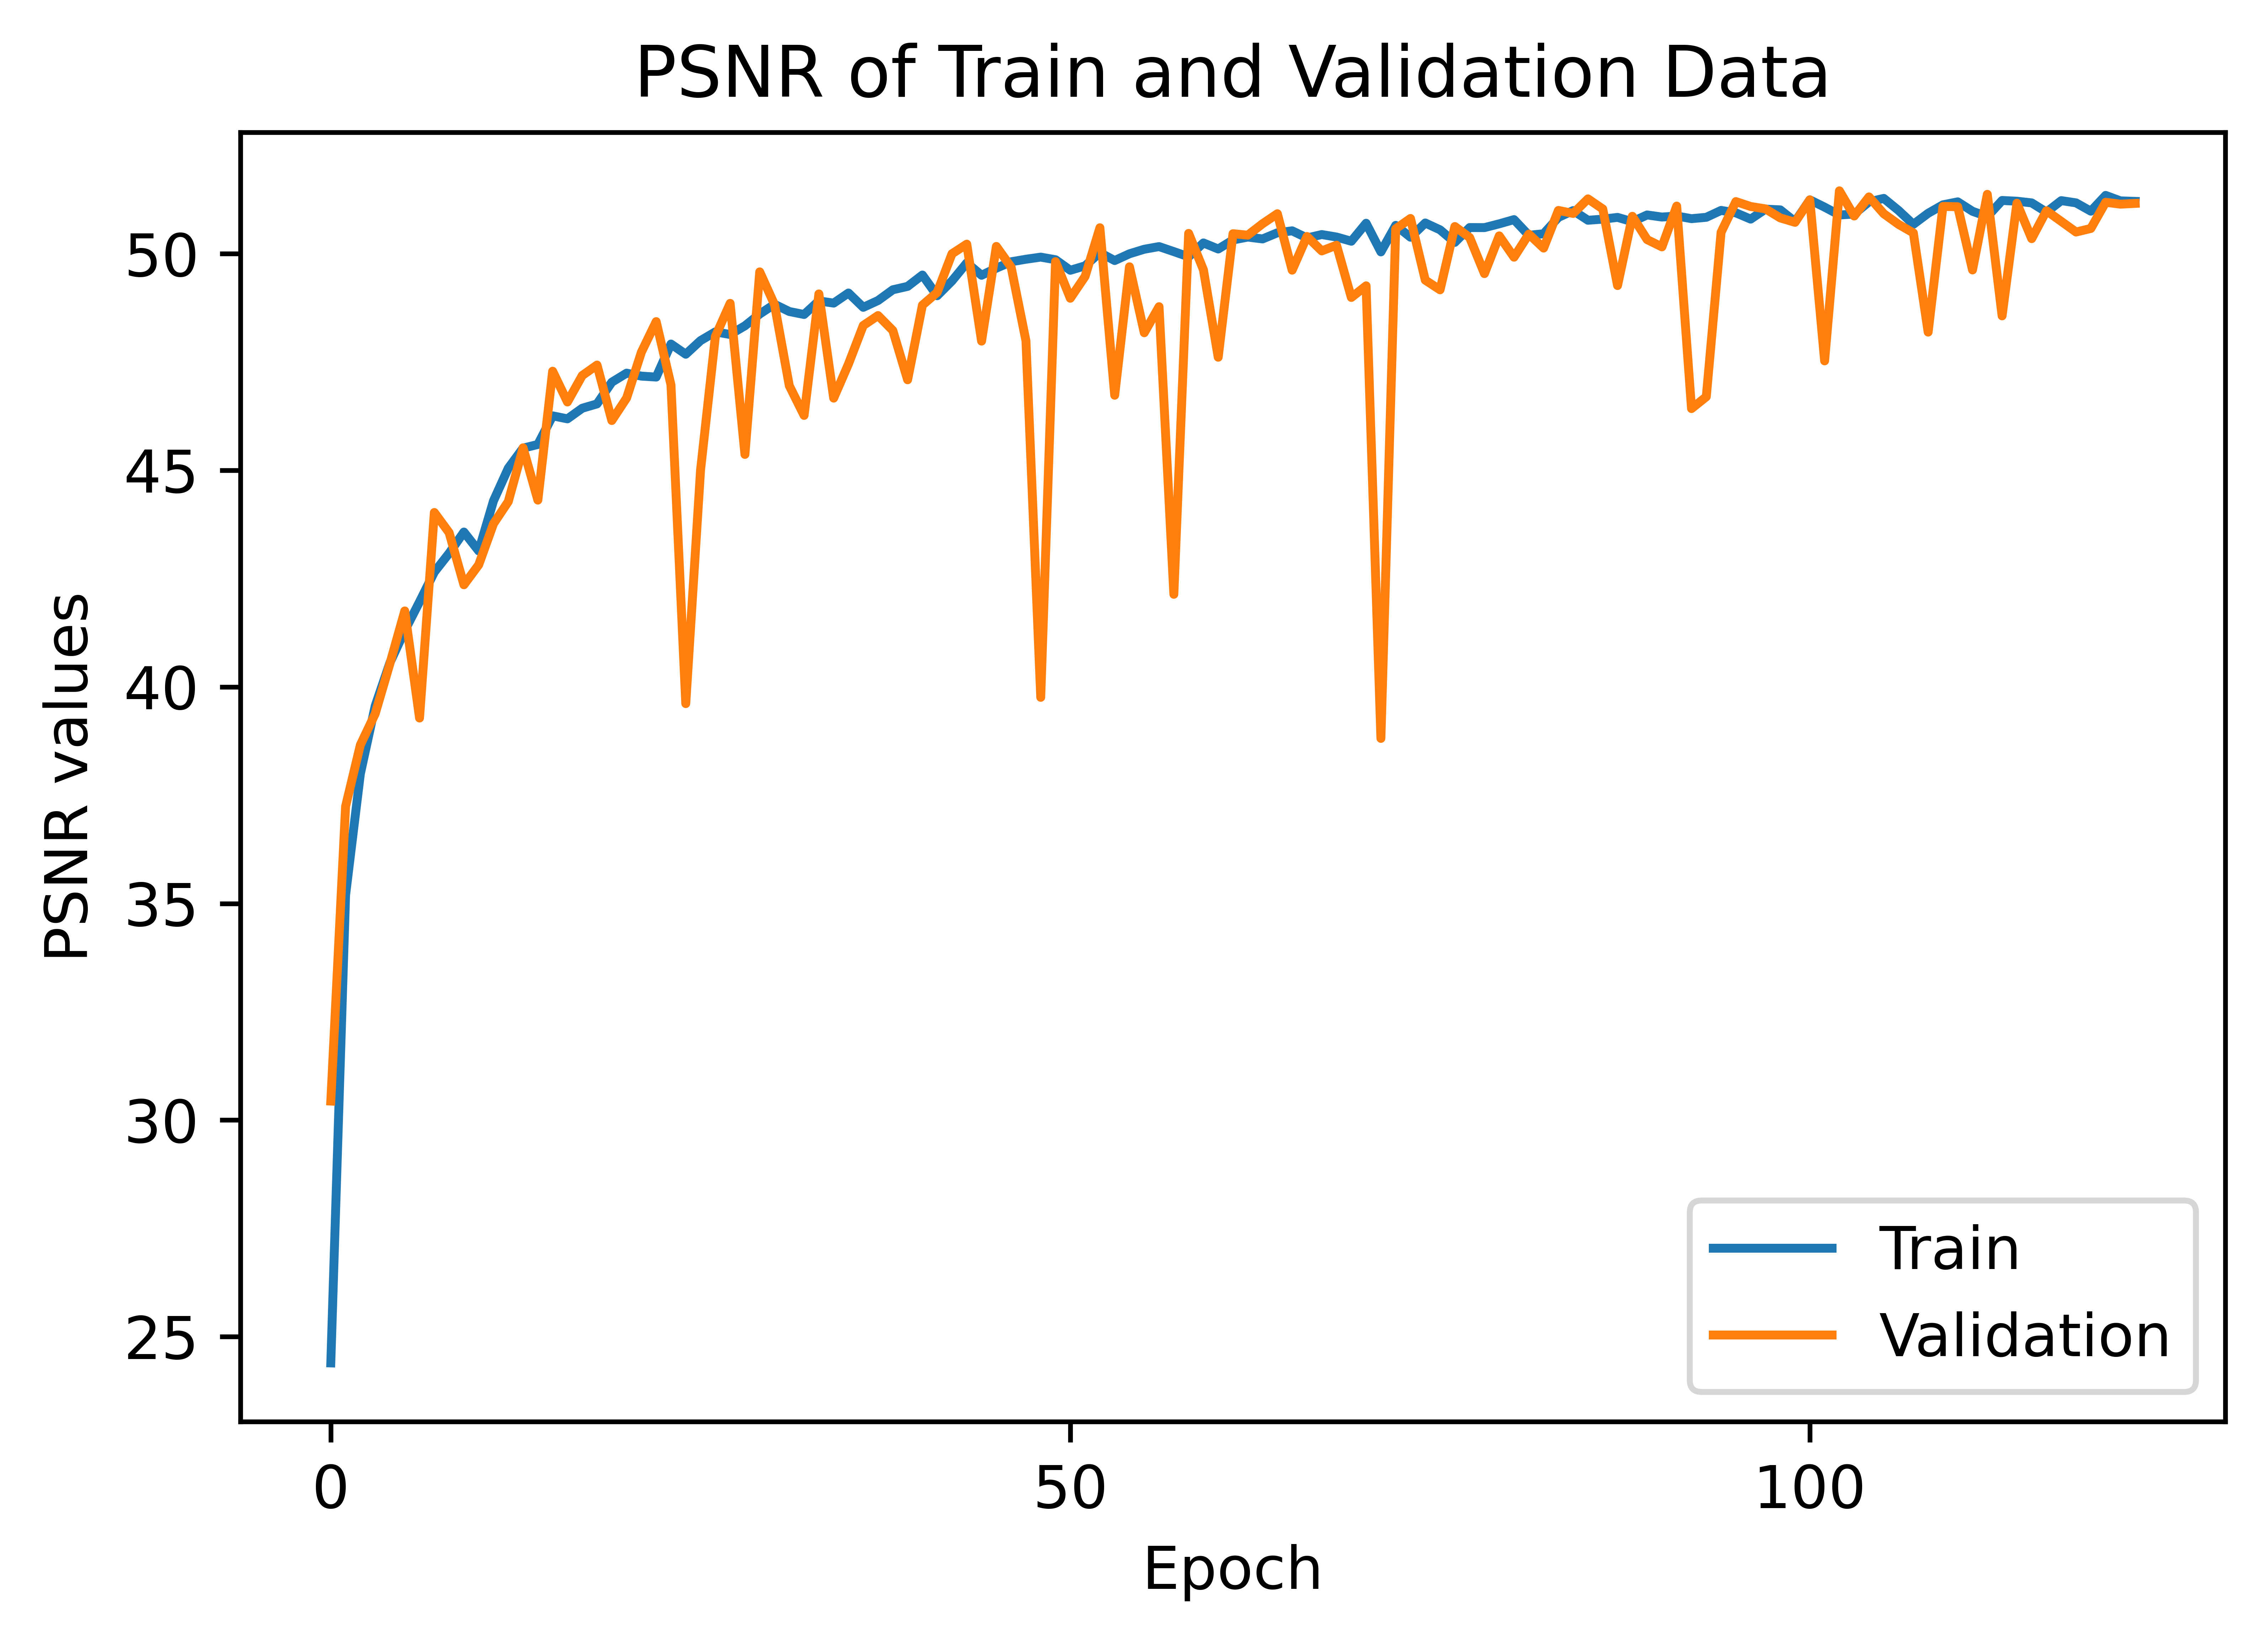

In [14]:
if __name__ == "__main__":
    start_training()